Now iterating over file
Sequences Processed
Embedding starts
Embedding complete
Embeddings shape: (27082, 512)
Embeddings per token: [[-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]
 [-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]
 [-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]
 ...
 [-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]
 [-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]
 [-0.20484564  0.80469364  0.6251794  ... -0.15700755 -0.11521544
  -0.01560736]]


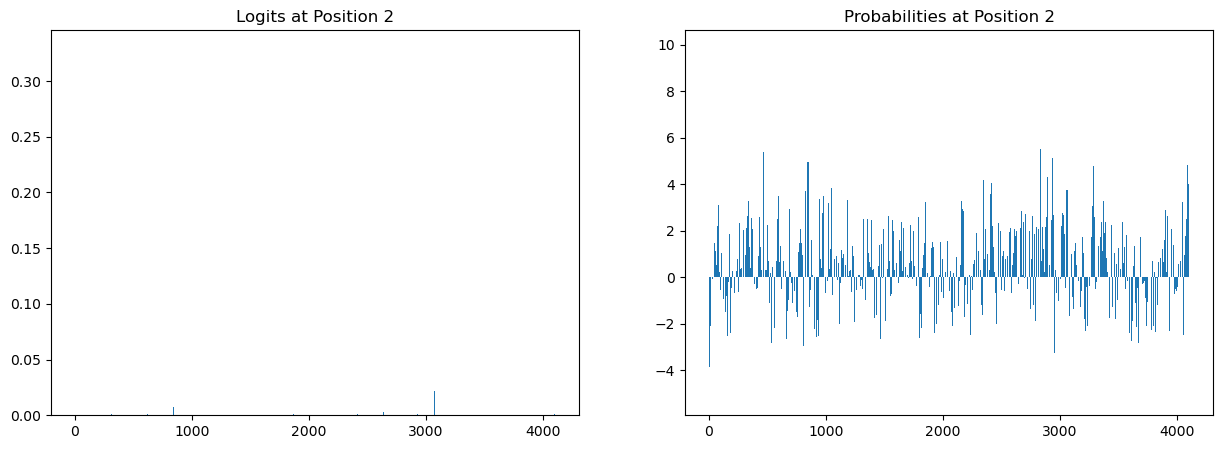

Top-5 Probabilities at Position 2:
N: 32.90%
CGTCCC: 3.46%
AATACT: 2.54%
CGGGGT: 2.14%
C: 2.07%


In [1]:
import os
import gzip
import glob
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
from Bio import SeqIO
from torch.utils.data import DataLoader

# Function to preprocess a DNA sequence
def preprocess_sequence(sequence):
    return sequence

def generate_sequence_embeddings(sequences, model, tokenizer, max_length, device, batch_size=64):
    # Placeholder for sequence embeddings and logits
    all_embeddings = []
    all_logits = []

    # Create a DataLoader for parallel tokenization
    data_loader = DataLoader(sequences, batch_size=batch_size, collate_fn=tokenizer.batch_encode_plus)

    # Iterate over batches
    for batch in data_loader:
        # Tokenize the batch of sequences with padding
        batch_encoding = tokenizer.batch_encode_plus(
            batch,
            return_tensors="pt",
            padding="max_length",
            max_length=max_length,
            truncation=True
        )
        tokens_ids = batch_encoding["input_ids"].to(device)

        # Compute the embeddings
        with torch.no_grad():
            torch_outs = model(
                tokens_ids,
                output_hidden_states=True
            )

        # Extract hidden states and compute sequence embeddings
        hidden_states = torch_outs['hidden_states']
        embeddings = hidden_states[-1][:, 0, :].detach().cpu().numpy()
        all_embeddings.append(embeddings)

        # Retrieve logits for each sequence in the batch
        logits = model.lm_head(hidden_states[-1])
        all_logits.append(logits)

    # Concatenate embeddings and logits from all batches
    embeddings = np.concatenate(all_embeddings, axis=0)
    logits = torch.cat(all_logits, dim=0)

    return embeddings, logits, model, tokenizer  # Return model and tokenizer

def show_top_k_probabilities(logits, tokenizer, position=0, k=5):
    # Ensure logits tensor has the expected shape
    if logits.ndim < 2:
        print(f"Error: Logits tensor has unexpected shape: {logits.shape}")
        return

    probabilities = F.softmax(logits[0, position], dim=-1).cpu().detach().numpy()
    top_k_indices = np.argsort(probabilities)[-k:][::-1]
    top_k_probabilities = probabilities[top_k_indices]
    top_k_tokens = [tokenizer.convert_ids_to_tokens([index])[0] for index in top_k_indices]

    print(f"Top-{k} Probabilities at Position {position + 1}:")
    for token, probability in zip(top_k_tokens, top_k_probabilities):
        print(f"{token}: {probability*100:.2f}%")  # Display probabilities in percentage

def plot_logits_and_probabilities(logits, vocab_size, position=0):
    plt.figure(figsize=(15, 5))

    # Plot logits
    plt.subplot(1, 2, 1)
    plt.bar(range(vocab_size), F.softmax(logits[0, position], dim=-1).cpu().detach().numpy())
    plt.title(f'Logits at Position {position + 1}')

    # Plot probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(vocab_size), logits[0, position].cpu().detach().numpy())
    plt.title(f'Probabilities at Position {position + 1}')

    plt.show()

# Function to process, generate embeddings, and plot results
def process_and_plot(folder_path, num_files=1, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Lists to store preprocessed sequences
    processed_sequences = []

    # Get a list of all FastQ files in the folder
    fastq_files = glob.glob(os.path.join(folder_path, '*.fq.gz'))

    # Randomly select num_files files
    selected_files = random.sample(fastq_files, min(num_files, len(fastq_files)))

    # Initialize the tokenizer and the model
    tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True)
    model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True).to(device)
    
    # Choose the length to which the input sequences are padded
    max_length = 10  # Set your desired max_length here
    print("Now iterating over file")
    # Iterate over each selected FastQ file
    for i, file_path in enumerate(selected_files):
        with gzip.open(file_path, "rt") as handle:
            for record in SeqIO.parse(handle, "fastq"):
                # Preprocess sequence
                processed_sequence = preprocess_sequence(str(record.seq))
                processed_sequences.append(processed_sequence)

    print("Sequences Processed")

    # Generate sequence embeddings and logits
    print("Embedding starts")
    embeddings, logits, model, tokenizer = generate_sequence_embeddings(processed_sequences, model, tokenizer, max_length, device)
    print("Embedding complete")

    # Print embeddings shape and embeddings per token
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embeddings per token: {embeddings}")

    # Plot logits and probabilities for a specific position
    plot_logits_and_probabilities(logits, tokenizer.vocab_size, position=1)

    # Show top-k probabilities and corresponding tokens at a specific position
    show_top_k_probabilities(logits, tokenizer, position=1, k=5)

    return embeddings, logits, model, tokenizer, processed_sequences  # Return embeddings, logits, model, tokenizer

# Example usage:
folder_path = '/var/microbiome/Eukaryotev2'
embeddings, logits, model, tokenizer, processed_sequences = process_and_plot(folder_path, num_files=2)


In [2]:
#!pip install umap-learn

2023-12-13 11:51:38.608545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-13 11:51:38.608685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-13 11:51:38.608697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


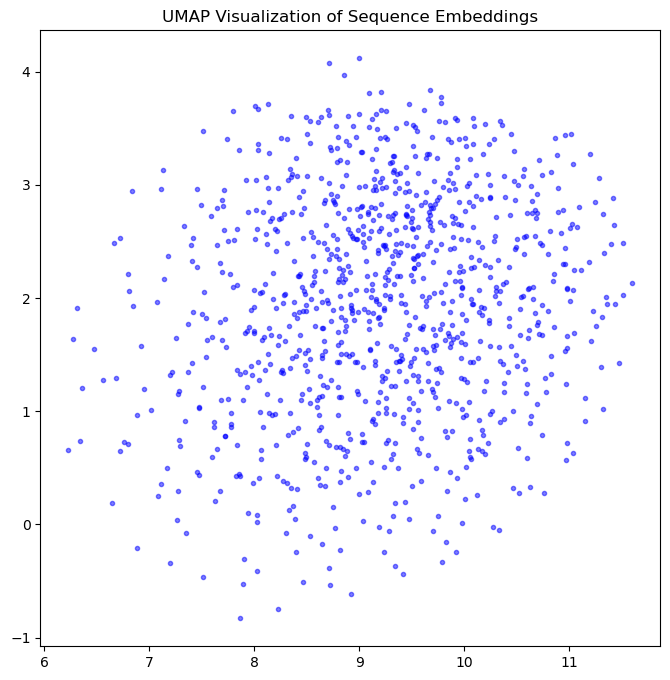

In [3]:
#visualizing embeddings
import umap

# Assuming 'embeddings' is the variable containing your embeddings
# You may want to use a subset of embeddings for faster visualization
subset_embeddings = embeddings[:1000]  # Adjust the subset size as needed

# Use UMAP for dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(subset_embeddings)

# Plot the UMAP embeddings
plt.figure(figsize=(8, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], marker='.', color='b', alpha=0.5)
plt.title('UMAP Visualization of Sequence Embeddings')
plt.show()


In [4]:
import io

# Assuming 'model' and 'tokenizer' are your model and tokenizer objects
weights = model.get_input_embeddings().weight.detach().cpu().numpy()
vocab = tokenizer.get_vocab()
words = [word for word, index in vocab.items()]

out_v = io.open('euk_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('euk_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(words):
    vec = weights[num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")

out_v.close()
out_m.close()


/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1d784195e0>
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packa

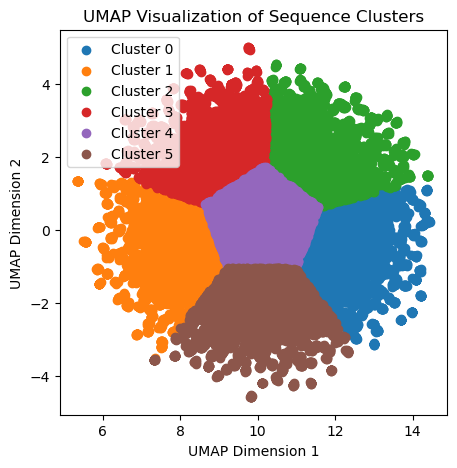

In [5]:

from sklearn.cluster import KMeans

# Step 1: UMAP Dimension Reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding_umap = reducer.fit_transform(embeddings)

# Step 2: Apply K-Means Clustering
num_clusters = 6  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_umap)

# Step 3: Visualize Clusters
plt.figure(figsize=(5, 5))
for i in range(num_clusters):
    plt.scatter(embedding_umap[cluster_labels == i, 0], embedding_umap[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('UMAP Visualization of Sequence Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import silhouette_score
#measuring cluster perfomance
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.0


In [7]:
kmeans_inertia = kmeans.inertia_
print(f"Inertia: {kmeans_inertia}")


Inertia: 37446.84375


/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1b6483ff70>
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packa

Silhouette Score cannot be calculated with only one unique label.


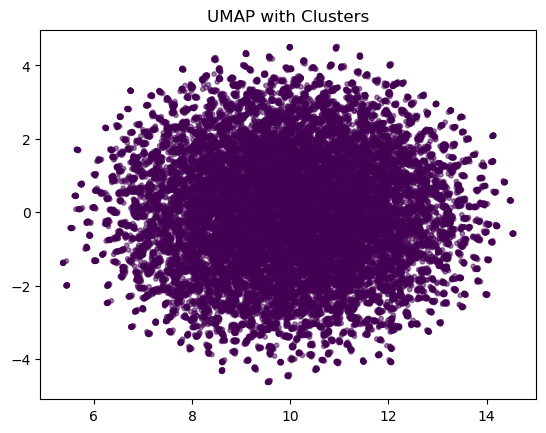

Cluster 1 - Representative Sequence: TCTGAGGATTTCACCACTGACAATTAAATACTAATGCCCCCAACTATCCCTATTAATCATTACTTCAGTCCCTCAAACCAACAAAGGAGACTAAAGTCCTATTCTATTATTCCATGCTAATGTATTCCGGCGCAAGCCTGCCTGAAACACTCTAATTTTCTCAAGGTAAAATATCTGAGCCCGAAACCAGTAACTGAATACCAAGAAACGTTAAAAGAAGGATGGAAGGGCGCCGCTG


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming you have 'embeddings' from the previous steps
# Let's say you want to try K-Means with a specific number of clusters, e.g., 3
num_clusters = 3

# Perform UMAP for dimension reduction
umap_model = UMAP(n_components=2, metric='euclidean')
reduced_embeddings = umap_model.fit_transform(embeddings)

# Perform K-Means clustering
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

kmeans_model = KMeans(n_clusters=num_clusters, init='random', random_state=42)
cluster_labels = kmeans_model.fit_predict(scaled_embeddings)

# Get representative sequences for each cluster
representative_sequences = []
for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    
    # Check if the cluster is not empty
    if len(cluster_indices) > 0:
        closest_to_center = np.argmin(np.linalg.norm(scaled_embeddings[cluster_indices], axis=1))
        representative_sequences.append(processed_sequences[cluster_indices[closest_to_center]])

# Silhouette Score
if len(np.unique(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(scaled_embeddings, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette Score cannot be calculated with only one unique label.")

# Visualize Clusters
# Plot the reduced embeddings without cluster centers
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, s=10)
plt.title('UMAP with Clusters')
plt.show()

# Plot representative sequences
for i, sequence in enumerate(representative_sequences):
    print(f"Cluster {i + 1} - Representative Sequence: {sequence}")
